In [1]:
import xgboost

print(xgboost.__version__)

0.90


In [2]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns = dataset.feature_names)
cancer_df['target'] = y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [3]:
cancer_df.shape

(569, 31)

In [4]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [5]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label,
                                                   test_size=0.2, random_state=37)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


In [6]:
dtrain = xgb.DMatrix(data = X_train, label = y_train)
dtest = xgb.DMatrix(data = X_test, label = y_test)

In [7]:
params = {"max_depth":3,
         'eta' : 0.1,
         'objective':'binary:logistic',
         'eval_metric':'logloss',
         'early_stoppings':100}

num_rounds = 400

In [8]:
# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval'로 명기합니다.
wlist = [(dtrain, 'train'), (dtest, 'eval')]

# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain = dtrain, num_boost_round = num_rounds, early_stopping_rounds=100, evals=wlist)

[0]	train-logloss:0.607514	eval-logloss:0.619621
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 100 rounds.
[1]	train-logloss:0.537227	eval-logloss:0.559986
[2]	train-logloss:0.477293	eval-logloss:0.510846
[3]	train-logloss:0.42723	eval-logloss:0.468197
[4]	train-logloss:0.385206	eval-logloss:0.430018
[5]	train-logloss:0.346184	eval-logloss:0.398063
[6]	train-logloss:0.312762	eval-logloss:0.371457
[7]	train-logloss:0.282948	eval-logloss:0.348233
[8]	train-logloss:0.25705	eval-logloss:0.328786
[9]	train-logloss:0.233721	eval-logloss:0.311519
[10]	train-logloss:0.213004	eval-logloss:0.296916
[11]	train-logloss:0.194585	eval-logloss:0.283559
[12]	train-logloss:0.178538	eval-logloss:0.270554
[13]	train-logloss:0.163755	eval-logloss:0.261289
[14]	train-logloss:0.150827	eval-logloss:0.252446
[15]	train-logloss:0.139397	eval-logloss:0.243831
[16]	train-logloss:0.128555	eval-logloss:0.236091
[17]	train-l

In [11]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10], 3))

#예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨
[0.734 1.    0.999 0.536 0.996 0.999 0.057 0.999 1.    0.001]
예측값 10개만 표시: [1, 1, 1, 1, 1, 1, 0, 1, 1, 0]


## get_clf_eval 함수

In [14]:
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred = None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print("오차행렬")
    print(confusion)
    # ROC-AUC print 추가
    print("정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}".format(accuracy, precision, recall, f1, roc_auc))

In [15]:
get_clf_eval(y_test, preds, pred_probs)

오차행렬
[[37  3]
 [ 2 72]]
정확도: 0.9561, 정밀도: 0.9600, 재현율: 0.9730, F1: 0.9664, AUC:0.9794


## feature importance 시각화

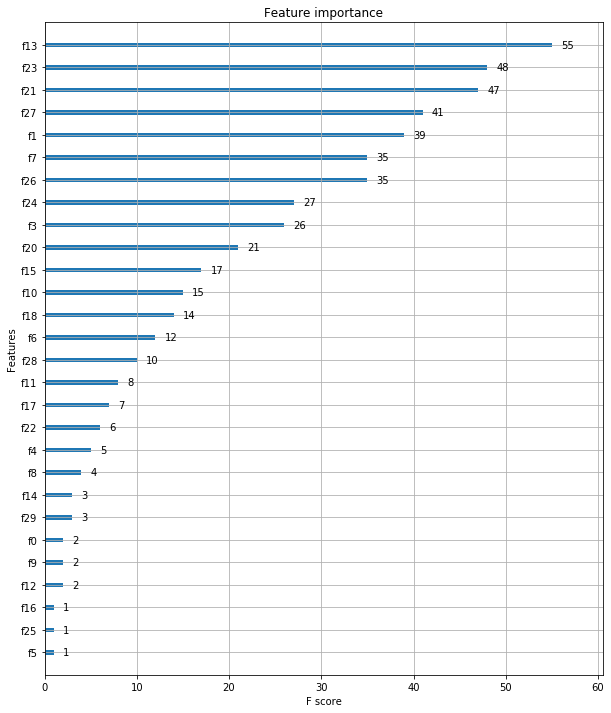

In [19]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (10, 12))
plot_importance(xgb_model, ax=ax)

## sklearn의 xgboost 래퍼 클래스 이용

In [22]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate = 0.1, max_depth = 3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [23]:
# 성능평가
get_clf_eval(y_test, w_preds, w_pred_proba)

오차행렬
[[37  3]
 [ 4 70]]
정확도: 0.9386, 정밀도: 0.9589, 재현율: 0.9459, F1: 0.9524, AUC:0.9791


In [24]:
# 조기중단 구현
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth = 3)
evals = [(X_test, y_test)]

xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)

ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.619621
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.559985
[2]	validation_0-logloss:0.510846
[3]	validation_0-logloss:0.468197
[4]	validation_0-logloss:0.430018
[5]	validation_0-logloss:0.398064
[6]	validation_0-logloss:0.371457
[7]	validation_0-logloss:0.348233
[8]	validation_0-logloss:0.328786
[9]	validation_0-logloss:0.311519
[10]	validation_0-logloss:0.296916
[11]	validation_0-logloss:0.283559
[12]	validation_0-logloss:0.270554
[13]	validation_0-logloss:0.261289
[14]	validation_0-logloss:0.252446
[15]	validation_0-logloss:0.243831
[16]	validation_0-logloss:0.236091
[17]	validation_0-logloss:0.228906
[18]	validation_0-logloss:0.222433
[19]	validation_0-logloss:0.218535
[20]	validation_0-logloss:0.215047
[21]	validation_0-logloss:0.21002
[22]	validation_0-logloss:0.206536
[23]	validation_0-logloss:0.203052
[24]	validation_0-logloss:0.199929
[25]	validation_0-logloss:0.197243
[26]	validation_0-logloss:0.1941

In [25]:
# 성능 평가
get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

오차행렬
[[37  3]
 [ 4 70]]
정확도: 0.9386, 정밀도: 0.9589, 재현율: 0.9459, F1: 0.9524, AUC:0.9620


In [28]:
# early_stopping_rounds를 10으로 설정하고 재 학습.
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds = 10, eval_metric='logloss', eval_set = evals, verbose=True)

ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

[0]	validation_0-logloss:0.619621
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.559985
[2]	validation_0-logloss:0.510846
[3]	validation_0-logloss:0.468197
[4]	validation_0-logloss:0.430018
[5]	validation_0-logloss:0.398064
[6]	validation_0-logloss:0.371457
[7]	validation_0-logloss:0.348233
[8]	validation_0-logloss:0.328786
[9]	validation_0-logloss:0.311519
[10]	validation_0-logloss:0.296916
[11]	validation_0-logloss:0.283559
[12]	validation_0-logloss:0.270554
[13]	validation_0-logloss:0.261289
[14]	validation_0-logloss:0.252446
[15]	validation_0-logloss:0.243831
[16]	validation_0-logloss:0.236091
[17]	validation_0-logloss:0.228906
[18]	validation_0-logloss:0.222433
[19]	validation_0-logloss:0.218535
[20]	validation_0-logloss:0.215047
[21]	validation_0-logloss:0.21002
[22]	validation_0-logloss:0.206536
[23]	validation_0-logloss:0.203052
[24]	validation_0-logloss:0.199929
[25]	validation_0-logloss:0.197243
[26]	validation_0-logloss:0.19414

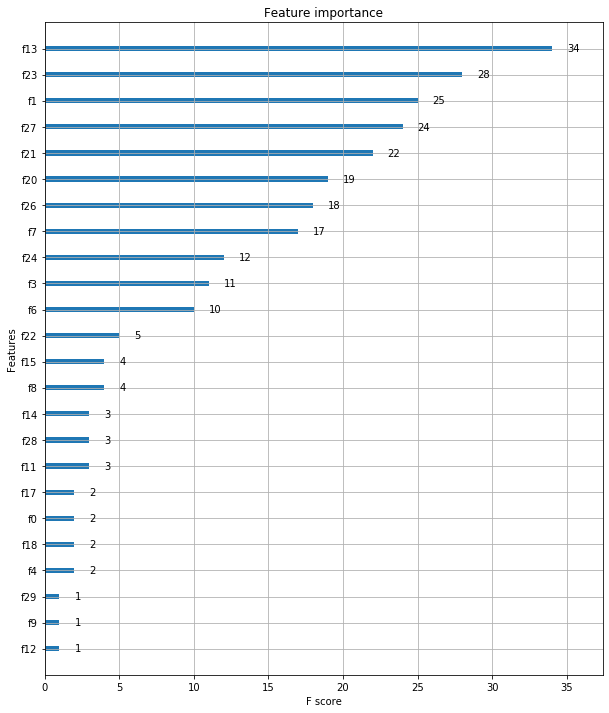

In [29]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
# 사이킷런 Wrapper 클래스를 입력해도 무방.
plot_importance(xgb_wrapper, ax=ax)